## Image classification with neural networks

**Table of Contents**

1. **Introduction**
   - Overview of the problem and dataset
2. **Check for CUDA Compatibility**
   - Ensure that the environment is set up for GPU acceleration.
3. **Data Preparation**
   - Loading and preprocessing the dataset
   - Creating train-test splits
4. **Training Setup**
   - Defining loss function, optimizer, and other training configurations
5. **Training the Model**
   - Training the neural network and monitoring performance
6. **Model Evaluation**
   - Calculating and displaying test set accuracy
   - Plotting example images with predictions
   - Generating and plotting a confusion matrix
7. **Results**
   - Summarizing the results


- The task involves classifying satellite images into 11 distinct classes based on land use or land cover, such as industrial areas, crops, rivers, and forests.
-The goal is to develop a neural network model that can accurately categorize these images into the correct class.

In [ ]:
!git clone https://github.com/jgscott/STA380.git

Cloning into 'STA380'...
remote: Enumerating objects: 35455, done.
remote: Counting objects: 100% (8430/8430), done.
remote: Compressing objects: 100% (7072/7072), done.
remote: Total 35455 (delta 1277), reused 8364 (delta 1253), pack-reused 27025 (from 1)
Receiving objects: 100% (35455/35455), 349.27 MiB | 26.44 MiB/s, done.
Resolving deltas: 100% (1280/1280), done.
Updating files: 100% (35750/35750), done.


- The dataset is organized into subdirectories within the EuroSAT_RGB directory, with each subdirectory corresponding to   11 classes.
- Each image is labeled by the directory it resides in, providing a straightforward way to load and process the data for supervised learning.

### Create Train Test Split

In [ ]:
from os import listdir
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18
import torch.nn as nn
from torch.optim import Adam
from torch.cuda import amp

In [ ]:
image_folder_root = "/content/STA380/data/EuroSAT_RGB"

# Define the transformation to convert PIL images to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert PIL images to tensors
])

dataset = ImageFolder(image_folder_root, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=0.001)

In [ ]:
scaler = amp.GradScaler()
prev_acc = 0
for epoch in range(10):  # Train for 10 epochs
    model.train()  # Set model to training mode
    total_loss = 0 # Initialize total loss for the epoch

     # Iterate over batches of training data
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # Zero the gradients before each forward pass

        with amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    # Print the average loss for the epoch
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        # Iterate over batches of test data
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate and print the accuracy on the test set
        acc = 100 * correct / total
        print(f'Test Accuracy: {acc}%')
        if acc > prev_acc:
            prev_acc = acc
            torch.save(model.state_dict(), f'fine_tuned_resnet18_{acc}_{epoch}.pth')

Epoch 1, Loss: 0.6315514760521742
Test Accuracy: 90.12962962962963%
Epoch 2, Loss: 0.3160018309862656
Test Accuracy: 91.24074074074075%
Epoch 3, Loss: 0.26372040539274555
Test Accuracy: 92.0925925925926%
Epoch 4, Loss: 0.23859741417525787
Test Accuracy: 92.5925925925926%
Epoch 5, Loss: 0.2223790975937829
Test Accuracy: 92.74074074074075%
Epoch 6, Loss: 0.21107677829909255
Test Accuracy: 92.72222222222223%
Epoch 7, Loss: 0.2075329158873953
Test Accuracy: 93.0%
Epoch 8, Loss: 0.2008062861639367
Test Accuracy: 93.14814814814815%
Epoch 9, Loss: 0.1964649349759669
Test Accuracy: 93.0%
Epoch 10, Loss: 0.18929599082240692
Test Accuracy: 93.14814814814815%


The test accuracy has come to 93.1%.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.utils import make_grid


In [ ]:
# Function to plot images with predictions
def show_images(images, labels, preds, classes):
    plt.figure(figsize=(12, 6))
    images = images.cpu()  # Move images to CPU
    labels = labels.cpu()  # Move labels to CPU
    preds = preds.cpu()    # Move predictions to CPU

    # Denormalize and plot the images
    images = make_grid(images, nrow=8, normalize=True).permute(1, 2, 0).numpy()
    plt.imshow(images)
    plt.title(f"True labels: {', '.join(classes[labels.numpy()])}\nPredicted: {', '.join(classes[preds.numpy()])}")
    plt.axis('off')
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}',
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Overall Test Accuracy: 93.15%


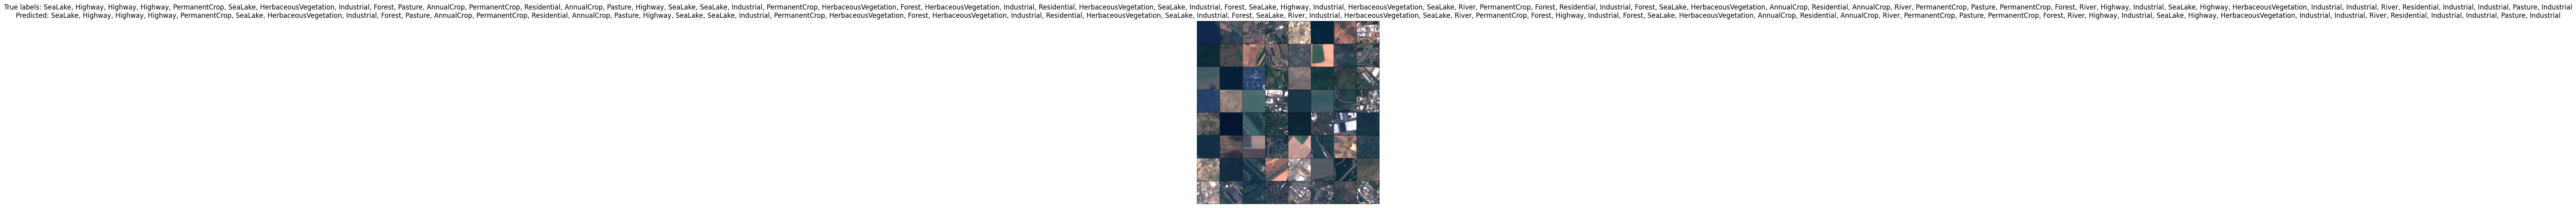

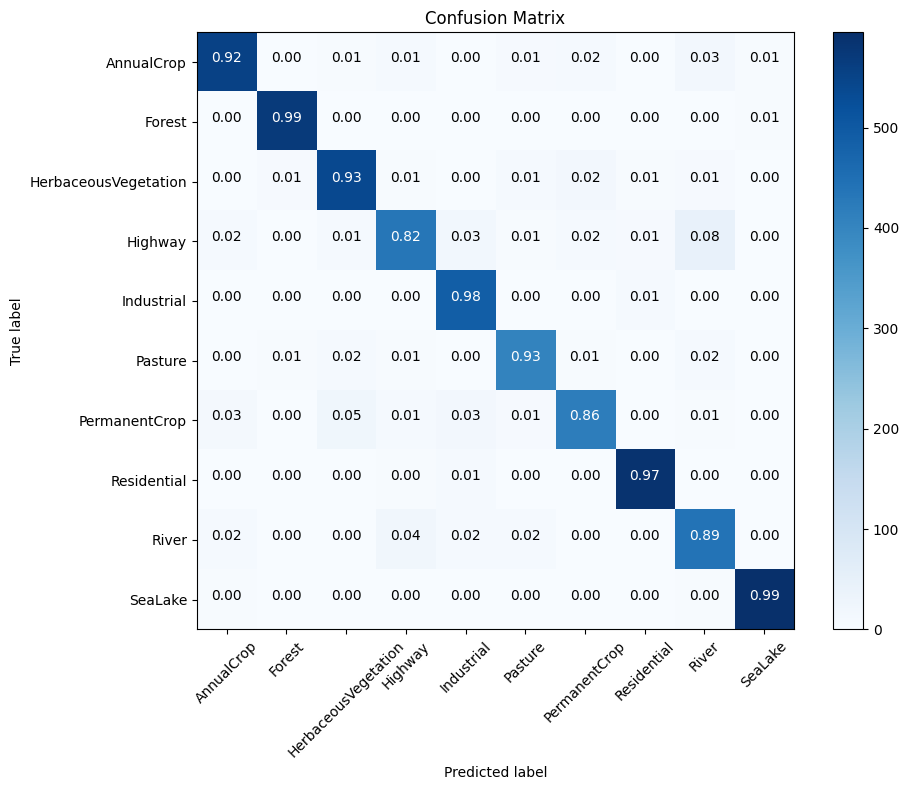

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.utils import make_grid

# Function to plot images with predictions
def show_images(images, labels, preds, classes):
    plt.figure(figsize=(12, 6))
    images = images.cpu()  # Move images to CPU
    labels = labels.cpu()  # Move labels to CPU
    preds = preds.cpu()    # Move predictions to CPU

    # Denormalize and plot the images
    images = make_grid(images, nrow=8, normalize=True).permute(1, 2, 0).numpy()
    plt.imshow(images)

    # Convert indices to class names
    true_labels = [classes[label] for label in labels.numpy()]
    predicted_labels = [classes[pred] for pred in preds.numpy()]

    plt.title(f"True labels: {', '.join(true_labels)}\nPredicted: {', '.join(predicted_labels)}")
    plt.axis('off')
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}',
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Evaluate the model
model.eval()
all_preds = []
all_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU
        all_labels.extend(labels.cpu().numpy())  # Move labels to CPU

# Calculate the overall test set accuracy
test_accuracy = accuracy_score(all_labels, all_preds) * 100
print(f'Overall Test Accuracy: {test_accuracy:.2f}%')

# Show some example images with predictions
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds, dataset.classes)
    break  # Show only one batch

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(conf_matrix, dataset.classes)

### Summary:

**Layers**: The model is based on the ResNet-18 architecture, customized for classifying satellite images.

1. **Input Layer**:
   - Handles RGB images with dimensions as expected by ResNet-18.

2. **Convolutional Layer**:
   - The initial layer consists of a convolution operation followed by max pooling, designed to extract basic features from the input images.

3. **Batch Normalization**:
   - Each convolutional layer is followed by batch normalization to stabilize and accelerate training.

4. **Activation Function**:
   - ReLU (Rectified Linear Unit) is used as the activation function throughout the network, introducing non-linearity.


**Performance**:
- The model's performance is monitored across 10 epochs, with accuracy on the test set recorded after each epoch. The model's weights are saved whenever a new best accuracy is achieved.
